/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_16627/3984662796.py:102: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  freedom_scores = events.groupby("playerName", dropna=False).apply(player_freedom)


=== Player Freedom Scores ===
playerName
A. Spina                  2.0207
J. Ontaneda               2.0179
A. Tobar                  2.0078
U. Ciccioli               1.9980
L. Mancinelli             1.9510
J. Ordóñez                1.9508
R. Jaramillo              1.9488
L. Estupiñán              1.9424
E. Segura                 1.9397
A. Rodríguez              1.9342
A. Mina                   1.9182
L. Gustavino              1.8972
B. Miranda                1.8960
R. Calderón               1.8783
Jonnathan Gabriel Mina    1.8771
C. Rolón                  1.8705
K. Moreno                 1.8433
E. Raggio                 1.8413
E. Guevara                1.8334
L. Cano                   1.8005
A. López                  1.7908
M. Sanabria               1.7350
M. Piedra                 1.7021
A. Almagro                1.6313
M. Maccari                1.5963
J. Chacón                 1.5698
B. Montenegro             1.5058
H. Piedra                 1.4921
B. Bustos                 1.4592
Na

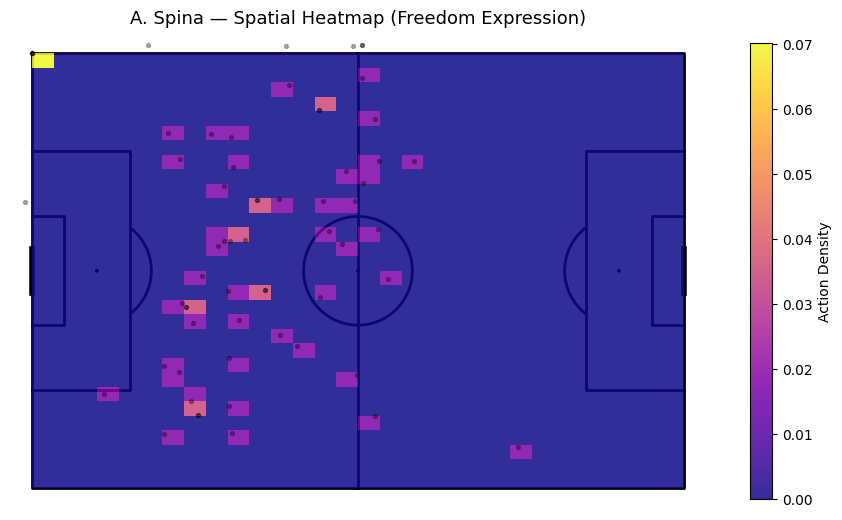

In [5]:
import json
import numpy as np
import pandas as pd
from scipy.stats import entropy
import matplotlib.pyplot as plt
from mplsoccer import Pitch

# === Load match data ===
with open("/Users/user/XG/Ecuador/2025-10-25_CD Cuenca - SD Aucas.json") as f:
    data = json.load(f)

events = pd.DataFrame(data["event"])
events = events[events["x"].notnull() & events["y"].notnull()].copy()

# --- Handle timestamps safely ---
if "timeStamp" in events.columns:
    try:
        events["timeStamp"] = pd.to_datetime(events["timeStamp"], errors="coerce", format="mixed")
    except Exception:
        events["timeStamp"] = pd.to_datetime(events["timeStamp"], errors="coerce")
else:
    events["timeStamp"] = pd.NaT

# --- Always create a numeric event time (in seconds) ---
events["eventTime"] = events["timeMin"] * 60 + events["timeSec"]

# =====================================================================
#                FREEDOM SCORE FUNCTION
# =====================================================================
def player_freedom(df):
    """Compute a multi-dimensional freedom score for a player's actions."""
    if df["timeStamp"].notna().any():
        df = df.sort_values("timeStamp")
    else:
        df = df.sort_values("eventTime")

    # 1️⃣ Spatial entropy (spread)
    H_spatial = entropy(
        np.histogram2d(df["x"], df["y"], bins=10, range=[[0, 100], [0, 100]])[0].flatten()
        + 1e-6
    )

    # 2️⃣ Action diversity
    H_action = entropy(df["typeId"].value_counts(normalize=True))

    # 3️⃣ Directional entropy
    dx = df["x"].diff().dropna()
    dy = df["y"].diff().dropna()
    if len(dx) > 1:
        angles = np.arctan2(dy, dx)
        H_dir = entropy(np.histogram(angles, bins=12, range=(-np.pi, np.pi))[0] + 1e-6)
    else:
        H_dir = 0

    # 4️⃣ Tempo variability
    if df["timeStamp"].notna().any():
        deltas = df["timeStamp"].diff().dt.total_seconds().dropna()
    else:
        deltas = df["eventTime"].diff().dropna()
    V_tempo = np.std(deltas) if len(deltas) > 1 else 0
    V_tempo_norm = min(V_tempo / 10.0, 1.0)

    # 5️⃣ Interaction diversity
    pass_targets = []
    for qlist in df.get("qualifier", []):
        if isinstance(qlist, list):
            for q in qlist:
                if q.get("qualifierId") in (194, 233, 385):  # teammate / pass IDs
                    pass_targets.append(q.get("value"))
    H_teammate = len(set(pass_targets)) / (len(pass_targets) + 1e-6)

    # 6️⃣ Role fluidity
    xzones = np.digitize(df["x"], np.linspace(0, 100, 5))
    yzones = np.digitize(df["y"], np.linspace(0, 100, 5))
    zones = xzones * 10 + yzones
    F_role = len(np.unique(zones)) / 25.0

    # Weighted combination
    weights = {
        "H_spatial": 0.25,
        "H_action": 0.20,
        "H_dir": 0.20,
        "V_tempo": 0.15,
        "H_teammate": 0.10,
        "F_role": 0.10,
    }

    score = (
        weights["H_spatial"] * H_spatial
        + weights["H_action"] * H_action
        + weights["H_dir"] * H_dir
        + weights["V_tempo"] * V_tempo_norm
        + weights["H_teammate"] * H_teammate
        + weights["F_role"] * F_role
    )
    return score


# =====================================================================
#                COMPUTE FREEDOM SCORES
# =====================================================================
freedom_scores = events.groupby("playerName", dropna=False).apply(player_freedom)
freedom_scores = freedom_scores.sort_values(ascending=False)

print("=== Player Freedom Scores ===")
print(freedom_scores.round(4))

# =====================================================================
#                M P L S O C C E R   P L O T S
# =====================================================================
def plot_player_heatmap(player_name, df):
    """Visualize player action density on a soccer pitch using mplsoccer."""
    player_events = df[df["playerName"] == player_name]
    if player_events.empty:
        print(f"No data for player {player_name}")
        return

    pitch = Pitch(pitch_type="statsbomb", pitch_color="white", line_color="black")
    fig, ax = pitch.draw(figsize=(9, 6))

    # Heatmap
    bin_statistic = pitch.bin_statistic(
        player_events["x"], player_events["y"],
        bins=(30, 30), statistic="count", normalize=True
    )
    pcm = pitch.heatmap(
        bin_statistic, ax=ax, cmap="plasma", edgecolors="none", alpha=0.85
    )

    pitch.scatter(
        player_events["x"], player_events["y"], ax=ax, s=8, color="black", alpha=0.3
    )

    fig.colorbar(pcm, ax=ax, shrink=0.8, label="Action Density")
    plt.title(f"{player_name} — Spatial Heatmap (Freedom Expression)", fontsize=13)
    plt.show()


# =====================================================================
#                EXAMPLE USAGE
# =====================================================================

# Show top 5 most "free" players
print("\nTop 5 players by Freedom Score:\n")
print(freedom_scores.head(5))

# Plot top player
top_player = freedom_scores.idxmax()
print(f"\nPlotting heatmap for most 'free' player: {top_player}")
plot_player_heatmap(top_player, events)


/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_16627/1206935124.py:101: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  freedom_scores = events.groupby("playerName", dropna=False).apply(player_freedom)
/opt/anaconda3/lib/python3.12/site-packages/mplsoccer/_pitch_plot.py:167: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  return sns.kdeplot(x=x, y=y, ax=ax, clip=self.kde_clip, **kwargs)


=== Player Freedom Scores ===
playerName
A. Spina                  2.0207
J. Ontaneda               2.0179
A. Tobar                  2.0078
U. Ciccioli               1.9980
L. Mancinelli             1.9510
J. Ordóñez                1.9508
R. Jaramillo              1.9488
L. Estupiñán              1.9424
E. Segura                 1.9397
A. Rodríguez              1.9342
A. Mina                   1.9182
L. Gustavino              1.8972
B. Miranda                1.8960
R. Calderón               1.8783
Jonnathan Gabriel Mina    1.8771
C. Rolón                  1.8705
K. Moreno                 1.8433
E. Raggio                 1.8413
E. Guevara                1.8334
L. Cano                   1.8005
A. López                  1.7908
M. Sanabria               1.7350
M. Piedra                 1.7021
A. Almagro                1.6313
M. Maccari                1.5963
J. Chacón                 1.5698
B. Montenegro             1.5058
H. Piedra                 1.4921
B. Bustos                 1.4592
Na

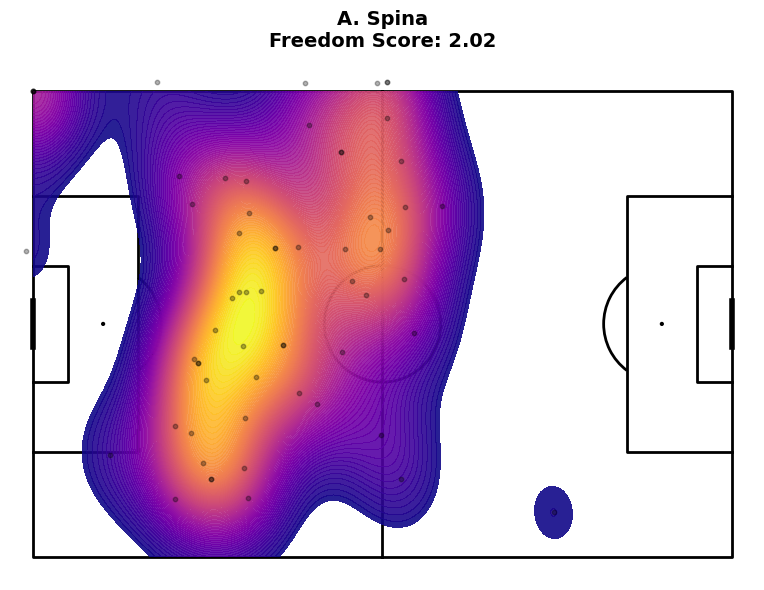

/opt/anaconda3/lib/python3.12/site-packages/mplsoccer/_pitch_plot.py:167: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  return sns.kdeplot(x=x, y=y, ax=ax, clip=self.kde_clip, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/mplsoccer/_pitch_plot.py:167: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  return sns.kdeplot(x=x, y=y, ax=ax, clip=self.kde_clip, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/mplsoccer/_pitch_plot.py:167: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  return sns.kdeplot(x=x, y=y, ax=ax, clip=self.kde_clip, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/mplsoccer/_pitch_plot.py:167: FutureWarning: 

`shade` is now 

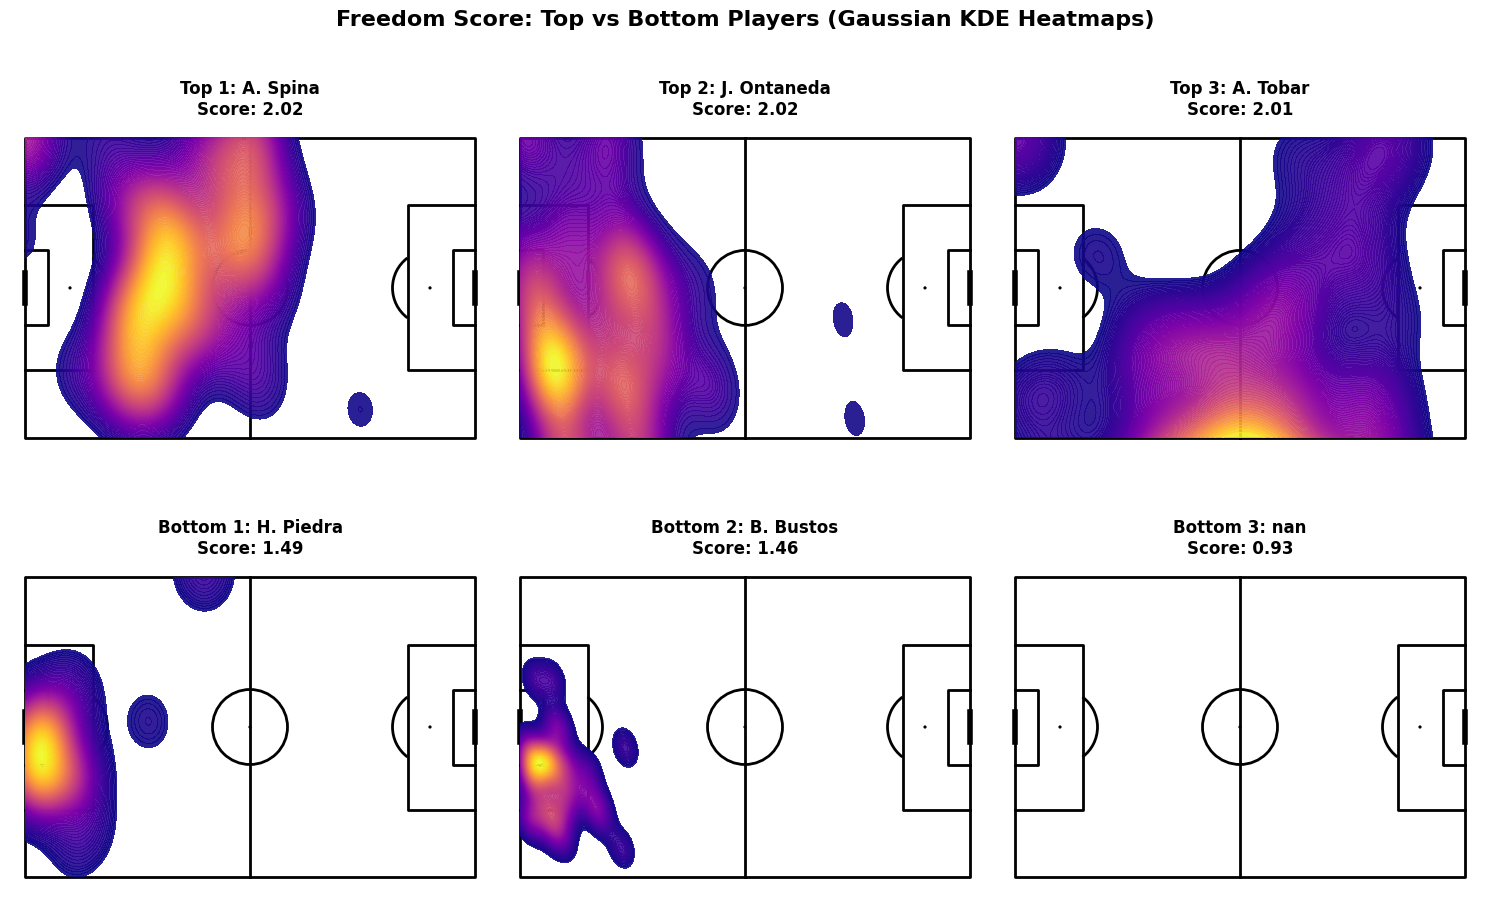

In [7]:
import json
import numpy as np
import pandas as pd
from scipy.stats import entropy
import matplotlib.pyplot as plt
from mplsoccer import Pitch

# === Load match data ===
with open("/Users/user/XG/Ecuador/2025-10-25_CD Cuenca - SD Aucas.json") as f:
    data = json.load(f)

events = pd.DataFrame(data["event"])
events = events[events["x"].notnull() & events["y"].notnull()].copy()

# --- Handle timestamps safely ---
if "timeStamp" in events.columns:
    try:
        events["timeStamp"] = pd.to_datetime(events["timeStamp"], errors="coerce", format="mixed")
    except Exception:
        events["timeStamp"] = pd.to_datetime(events["timeStamp"], errors="coerce")
else:
    events["timeStamp"] = pd.NaT

# --- Always create a numeric event time (in seconds) ---
events["eventTime"] = events["timeMin"] * 60 + events["timeSec"]

# =====================================================================
#                FREEDOM SCORE FUNCTION
# =====================================================================
def player_freedom(df):
    """Compute a multi-dimensional freedom score for a player's actions."""
    if df["timeStamp"].notna().any():
        df = df.sort_values("timeStamp")
    else:
        df = df.sort_values("eventTime")

    # 1️⃣ Spatial entropy (spread)
    H_spatial = entropy(
        np.histogram2d(df["x"], df["y"], bins=10, range=[[0, 100], [0, 100]])[0].flatten()
        + 1e-6
    )

    # 2️⃣ Action diversity
    H_action = entropy(df["typeId"].value_counts(normalize=True))

    # 3️⃣ Directional entropy
    dx = df["x"].diff().dropna()
    dy = df["y"].diff().dropna()
    if len(dx) > 1:
        angles = np.arctan2(dy, dx)
        H_dir = entropy(np.histogram(angles, bins=12, range=(-np.pi, np.pi))[0] + 1e-6)
    else:
        H_dir = 0

    # 4️⃣ Tempo variability
    if df["timeStamp"].notna().any():
        deltas = df["timeStamp"].diff().dt.total_seconds().dropna()
    else:
        deltas = df["eventTime"].diff().dropna()
    V_tempo = np.std(deltas) if len(deltas) > 1 else 0
    V_tempo_norm = min(V_tempo / 10.0, 1.0)

    # 5️⃣ Interaction diversity (pass targets)
    pass_targets = []
    for qlist in df.get("qualifier", []):
        if isinstance(qlist, list):
            for q in qlist:
                if q.get("qualifierId") in (194, 233, 385):  # teammate/pass IDs
                    pass_targets.append(q.get("value"))
    H_teammate = len(set(pass_targets)) / (len(pass_targets) + 1e-6)

    # 6️⃣ Role fluidity (zones occupied)
    xzones = np.digitize(df["x"], np.linspace(0, 100, 5))
    yzones = np.digitize(df["y"], np.linspace(0, 100, 5))
    zones = xzones * 10 + yzones
    F_role = len(np.unique(zones)) / 25.0

    # Weighted combination
    weights = {
        "H_spatial": 0.25,
        "H_action": 0.20,
        "H_dir": 0.20,
        "V_tempo": 0.15,
        "H_teammate": 0.10,
        "F_role": 0.10,
    }

    score = (
        weights["H_spatial"] * H_spatial
        + weights["H_action"] * H_action
        + weights["H_dir"] * H_dir
        + weights["V_tempo"] * V_tempo_norm
        + weights["H_teammate"] * H_teammate
        + weights["F_role"] * F_role
    )
    return score

# =====================================================================
#                COMPUTE FREEDOM SCORES
# =====================================================================
freedom_scores = events.groupby("playerName", dropna=False).apply(player_freedom)
freedom_scores = freedom_scores.sort_values(ascending=False)

print("=== Player Freedom Scores ===")
print(freedom_scores.round(4))

# =====================================================================
#                M P L S O C C E R   G A U S S I A N  H E A T M A P
# =====================================================================
def plot_player_gaussian(player_name, df, score):
    """Visualize player's positional freedom with a Gaussian (KDE) heatmap."""
    player_events = df[df["playerName"] == player_name]
    if player_events.empty:
        print(f"No data for player {player_name}")
        return

    pitch = Pitch(pitch_type="statsbomb", pitch_color="white", line_color="black")
    fig, ax = pitch.draw(figsize=(9, 6))

    # Gaussian KDE heatmap
    pitch.kdeplot(
        player_events["x"],
        player_events["y"],
        ax=ax,
        shade=True,
        shade_lowest=False,
        cmap="plasma",
        alpha=0.9,
        levels=100,
        fill=True,
        bw_adjust=0.7  # smaller = smoother; tweak if too sharp/blurry
    )

    pitch.scatter(
        player_events["x"], player_events["y"], ax=ax, s=10, color="black", alpha=0.3
    )

    plt.title(
        f"{player_name}\nFreedom Score: {score:.2f}",
        fontsize=14, fontweight="bold", pad=15
    )
    plt.show()


def plot_top_bottom_gaussian(players_scores, df, top_n=3):
    """Compare top-N and bottom-N players with Gaussian heatmaps."""
    top_players = players_scores.head(top_n)
    bottom_players = players_scores.tail(top_n)

    fig, axes = plt.subplots(2, top_n, figsize=(5 * top_n, 10))
    pitch = Pitch(pitch_type="statsbomb", pitch_color="white", line_color="black")

    # --- Top players ---
    for i, (name, score) in enumerate(top_players.items()):
        ax = axes[0, i]
        pitch.draw(ax=ax)
        player_events = df[df["playerName"] == name]
        pitch.kdeplot(
            player_events["x"], player_events["y"],
            ax=ax, shade=True, cmap="plasma",
            alpha=0.9, fill=True, levels=100, bw_adjust=0.7
        )
        ax.set_title(f"Top {i+1}: {name}\nScore: {score:.2f}", fontsize=12, fontweight="bold")

    # --- Bottom players ---
    for i, (name, score) in enumerate(bottom_players.items()):
        ax = axes[1, i]
        pitch.draw(ax=ax)
        player_events = df[df["playerName"] == name]
        pitch.kdeplot(
            player_events["x"], player_events["y"],
            ax=ax, shade=True, cmap="plasma",
            alpha=0.9, fill=True, levels=100, bw_adjust=0.7
        )
        ax.set_title(f"Bottom {i+1}: {name}\nScore: {score:.2f}", fontsize=12, fontweight="bold")

    plt.suptitle("Freedom Score: Top vs Bottom Players (Gaussian KDE Heatmaps)",
                 fontsize=16, fontweight="bold")
    plt.tight_layout()
    plt.show()


# =====================================================================
#                EXAMPLE USAGE
# =====================================================================
print("\nTop 5 players by Freedom Score:\n")
print(freedom_scores.head(5))

# Plot top player's Gaussian heatmap
top_player = freedom_scores.idxmax()
plot_player_gaussian(top_player, events, freedom_scores[top_player])

# Compare top vs bottom 3 players (Gaussian)
plot_top_bottom_gaussian(freedom_scores, events, top_n=3)


In [48]:
import os
import json
import numpy as np
import pandas as pd
from scipy.stats import entropy
from tqdm import tqdm
import warnings

warnings.filterwarnings("ignore")

# =====================================================================
# 🔧 LOAD TEAM MAPPING FROM CSV
# =====================================================================
teams_path = "/Users/user/XG/Norway 2025 Matches.csv"  # <-- update this
teams_df = pd.read_csv(teams_path)

# Build mapping: contestantId → Team name
team_map = dict(zip(
    teams_df["matchInfo/contestant/0/id"],
    teams_df["matchInfo/contestant/0/name"]
))

if (
    "matchInfo/contestant/1/id" in teams_df.columns
    and "matchInfo/contestant/1/name" in teams_df.columns
):
    team_map.update(dict(zip(
        teams_df["matchInfo/contestant/1/id"],
        teams_df["matchInfo/contestant/1/name"]
    )))

print(f"✅ Loaded {len(team_map)} team mappings from CSV")


# =====================================================================
# FREEDOM SCORE FUNCTION
# =====================================================================
def player_freedom(df):
    """Compute a multi-dimensional freedom score for a player's actions."""
    if df["timeStamp"].notna().any():
        df = df.sort_values("timeStamp")
    else:
        df = df.sort_values("eventTime")

    # 1️⃣ Spatial entropy
    H_spatial = entropy(
        np.histogram2d(df["x"], df["y"], bins=10, range=[[0, 100], [0, 100]])[0].flatten()
        + 1e-6
    )

    # 2️⃣ Action diversity
    H_action = entropy(df["typeId"].value_counts(normalize=True))

    # 3️⃣ Directional entropy
    dx = df["x"].diff().dropna()
    dy = df["y"].diff().dropna()
    if len(dx) > 1:
        angles = np.arctan2(dy, dx)
        H_dir = entropy(np.histogram(angles, bins=12, range=(-np.pi, np.pi))[0] + 1e-6)
    else:
        H_dir = 0

    # 4️⃣ Tempo variability
    if df["timeStamp"].notna().any():
        deltas = df["timeStamp"].diff().dt.total_seconds().dropna()
    else:
        deltas = df["eventTime"].diff().dropna()
    V_tempo = np.std(deltas) if len(deltas) > 1 else 0
    V_tempo_norm = min(V_tempo / 10.0, 1.0)

    # 5️⃣ Interaction diversity (pass targets)
    pass_targets = []
    for qlist in df.get("qualifier", []):
        if isinstance(qlist, list):
            for q in qlist:
                if q.get("qualifierId") in (194, 233, 385):
                    pass_targets.append(q.get("value"))
    H_teammate = len(set(pass_targets)) / (len(pass_targets) + 1e-6)

    # 6️⃣ Role fluidity (zones occupied)
    xzones = np.digitize(df["x"], np.linspace(0, 100, 5))
    yzones = np.digitize(df["y"], np.linspace(0, 100, 5))
    zones = xzones * 10 + yzones
    F_role = len(np.unique(zones)) / 25.0

    # Weighted combination
    weights = {
        "H_spatial": 0.25,
        "H_action": 0.20,
        "H_dir": 0.20,
        "V_tempo": 0.15,
        "H_teammate": 0.10,
        "F_role": 0.10,
    }

    score = (
        weights["H_spatial"] * H_spatial
        + weights["H_action"] * H_action
        + weights["H_dir"] * H_dir
        + weights["V_tempo"] * V_tempo_norm
        + weights["H_teammate"] * H_teammate
        + weights["F_role"] * F_role
    )
    return score


# =====================================================================
# LOAD ALL JSON FILES + COMPUTE TEAM SCORES
# =====================================================================
folder_path = "/Users/user/XG/Norway 2025"  # 🧭 change to your match folder
results = []

for file in tqdm(os.listdir(folder_path), desc="Processing match files"):
    if not file.endswith(".json"):
        continue

    file_path = os.path.join(folder_path, file)
    try:
        with open(file_path) as f:
            data = json.load(f)
    except Exception as e:
        print(f"❌ Failed to load {file}: {e}")
        continue

    if "event" not in data:
        print(f"⚠️ No 'event' key in {file}")
        continue

    events = pd.DataFrame(data["event"])
    if events.empty:
        print(f"⚠️ No events in {file}")
        continue

    # --- Ensure coordinate columns exist ---
    if "x" not in events.columns or "y" not in events.columns:
        print(f"⚠️ Missing coordinate columns in {file}")
        continue

    # --- Map team identifiers to names ---
    if "teamName" not in events.columns:
        if "teamId" in events.columns:
            events["teamName"] = events["teamId"].map(team_map)
        elif "contestantId" in events.columns:
            events["teamName"] = events["contestantId"].map(team_map)
        else:
            print(f"⚠️ No teamId/contestantId in {file}")
            continue

    events = events[events["x"].notnull() & events["y"].notnull()].copy()

    # --- Handle timestamps ---
    if "timeStamp" in events.columns:
        try:
            events["timeStamp"] = pd.to_datetime(events["timeStamp"], errors="coerce", format="mixed")
        except Exception:
            events["timeStamp"] = pd.to_datetime(events["timeStamp"], errors="coerce")
    else:
        events["timeStamp"] = pd.NaT

    # Numeric event time
    events["eventTime"] = events.get("timeMin", 0) * 60 + events.get("timeSec", 0)

    # --- Compute player-level scores ---
    try:
        player_scores = events.groupby("playerName", dropna=False).apply(player_freedom)
        player_scores.name = "freedom"
    except Exception as e:
        print(f"⚠️ Error computing player scores for {file}: {e}")
        continue

    merged = events.merge(player_scores, on="playerName", how="left")

    if merged["teamName"].isna().all():
        print(f"⚠️ No team names could be resolved in {file}")
        continue

    # --- Compute average team freedom score ---
    team_scores = merged.groupby("teamName")["freedom"].mean().reset_index()

    if team_scores.empty:
        print(f"⚠️ No valid team scores in {file}")
        continue

    for _, row in team_scores.iterrows():
        results.append({
            "match_file": file,
            "team": row["teamName"],
            "team_freedom_score": row["freedom"]
        })

# =====================================================================
# SAVE RESULTS
# =====================================================================
if results:
    df_results = pd.DataFrame(results)
    df_results = df_results.sort_values(by="team_freedom_score", ascending=False)
    output_path = os.path.join(folder_path, "team_freedom_scores.csv")
    df_results.to_csv(output_path, index=False)
    print("\n✅ Team freedom scores saved to:", output_path)
    print(df_results.head(10))
else:
    print("\n⚠️ No team freedom scores computed. Check if 'contestantId' exists in your JSON structure.")


✅ Loaded 16 team mappings from CSV


Processing match files: 100%|██████████| 227/227 [01:05<00:00,  3.48it/s]


✅ Team freedom scores saved to: /Users/user/XG/Norway 2025/team_freedom_scores.csv
                                            match_file         team  \
381  2025-06-29_Bryne FK - Hamarkameratene Fotball....       HamKam   
74           2025-05-24_Bryne FK - Fredrikstad FK.json        Bryne   
349                2025-04-27_SK Brann - Bryne FK.json        Bryne   
407  2025-04-06_Sarpsborg 08 FF - Vålerenga Fotball...    Vålerenga   
380  2025-06-29_Bryne FK - Hamarkameratene Fotball....        Bryne   
168  2025-07-05_Vålerenga Fotball - Fredrikstad FK....  Fredrikstad   
118         2025-04-10_SK Brann - Strømsgodset IF.json        Brann   
134            2025-04-21_Bryne FK - FK Haugesund.json        Bryne   
355            2025-11-09_SK Brann - KFUM Fotball.json         KFUM   
46       2025-06-01_Bryne FK - Sandefjord Fotball.json        Bryne   

     team_freedom_score  
381            1.977257  
74             1.964197  
349            1.958429  
407            1.956548  
380 

✅ Boca Juniors: 4640 attacking-third events across matches matches

=== Player Freedom Scores in Attacking Third ===
playerName
M. Giménez       2.1270
E. Zeballos      2.0459
E. Cavani        2.0390
M. Merentiel     2.0183
A. Velasco       2.0117
T. Belmonte      1.9786
B. Aguirre       1.9573
K. Zenón         1.9284
A. Costa         1.9170
R. Battaglia     1.9147
C. Palacios      1.8933
Ander Herrera    1.8141
L. Paredes       1.7888
L. Di Lollo      1.7845
M. Braida        1.7835
W. Alarcón       1.7514
M. Delgado       1.7156
L. Blondel       1.6858
J. Barinaga      1.6517
M. Rojo          1.6365
L. Blanco        1.6255
L. Advíncula     1.6027
L. Janson        1.5409
M. Pellegrino    1.4386
I. Miramón       1.3629
NaN              1.3284
N. Figal         1.2553
M. Saracchi      1.0351
A. Marchesín     0.5946
S. Dalmasso      0.1044
dtype: float64


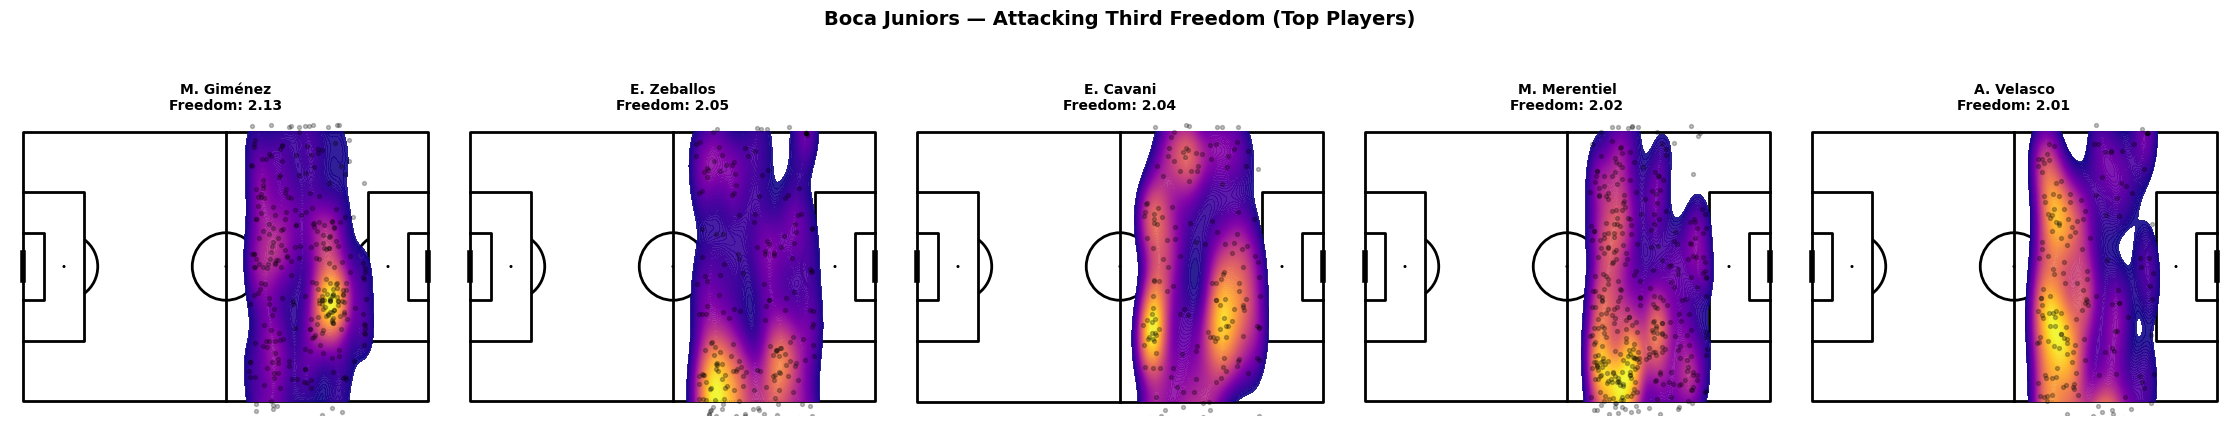

In [ ]:
# =====================================================================
# 🎯 Boca Juniors — Attacking Third Player Freedom
# =====================================================================
import matplotlib.pyplot as plt
from mplsoccer import Pitch

team_of_interest = "Rosenborg"
attacking_threshold = 66.7  # Attacking third (x in [0..100])

team_events_list = []

for file in sorted(os.listdir(folder_path)):
    if not file.endswith(".json"):
        continue

    file_path = os.path.join(folder_path, file)
    try:
        with open(file_path) as f:
            data = json.load(f)
    except Exception as e:
        print(f"❌ Failed to load {file}: {e}")
        continue

    if "event" not in data:
        continue

    ev = pd.DataFrame(data["event"])
    if ev.empty or "x" not in ev.columns or "y" not in ev.columns:
        continue

    # numeric coords
    ev["x"] = pd.to_numeric(ev["x"], errors="coerce")
    ev["y"] = pd.to_numeric(ev["y"], errors="coerce")
    ev = ev[ev["x"].notnull() & ev["y"].notnull()].copy()
    if ev.empty:
        continue

    # resolve teamName
    if "teamName" not in ev.columns:
        if "teamId" in ev.columns:
            ev["teamName"] = ev["teamId"].map(team_map)
        elif "contestantId" in ev.columns:
            ev["teamName"] = ev["contestantId"].map(team_map)

    boca = ev[ev["teamName"] == team_of_interest].copy()
    if boca.empty:
        continue

    # event time
    if "timeStamp" in boca.columns:
        try:
            boca["timeStamp"] = pd.to_datetime(boca["timeStamp"], errors="coerce", format="mixed")
        except Exception:
            boca["timeStamp"] = pd.to_datetime(boca["timeStamp"], errors="coerce")
    else:
        boca["timeStamp"] = pd.NaT
    boca["eventTime"] = boca.get("timeMin", 0).fillna(0)*60 + boca.get("timeSec", 0).fillna(0)

    # attacking third
    boca_att = boca[boca["x"] > attacking_threshold].copy()
    if boca_att.empty:
        continue

    team_events_list.append(boca_att)

if not team_events_list:
    raise ValueError(f"No attacking-third events found for {team_of_interest} in {folder_path}")

boca_attack_events = pd.concat(team_events_list, ignore_index=True)
print(f"✅ {team_of_interest}: {len(boca_attack_events)} attacking-third events across {boca_attack_events['match_file'].nunique() if 'match_file' in boca_attack_events.columns else 'matches'} matches")

# --- per-player freedom in attacking third
player_freedom_scores = (
    boca_attack_events.groupby("playerName", dropna=False)
    .apply(player_freedom)
    .sort_values(ascending=False)
)

print("\n=== Player Freedom Scores in Attacking Third ===")
print(player_freedom_scores.round(4))

# --- visualize top 5 players with KDE heatmaps
top_players = player_freedom_scores.head(5)

pitch = Pitch(pitch_type="statsbomb", pitch_color="white", line_color="black")
fig, axes = plt.subplots(1, len(top_players), figsize=(4.5*len(top_players), 5))

if len(top_players) == 1:
    axes = [axes]

for ax, (player, score) in zip(axes, top_players.items()):
    pitch.draw(ax=ax)
    pe = boca_attack_events[boca_attack_events["playerName"] == player]
    if not pe.empty:
        pitch.kdeplot(
            pe["x"], pe["y"],
            ax=ax, cmap="plasma", fill=True, levels=100, alpha=0.9, bw_adjust=0.7
        )
        pitch.scatter(pe["x"], pe["y"], ax=ax, s=8, color="black", alpha=0.25)
    ax.set_title(f"{player}\nFreedom: {score:.2f}", fontsize=10, fontweight="bold")

plt.suptitle(f"{team_of_interest} — Attacking Third Freedom (Top Players)", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()



=== Attacking Third — Freedom Score per Channel ===
       channel  freedom_score
1   Left flank          1.606
0      Central          1.982
2  Right flank          1.646


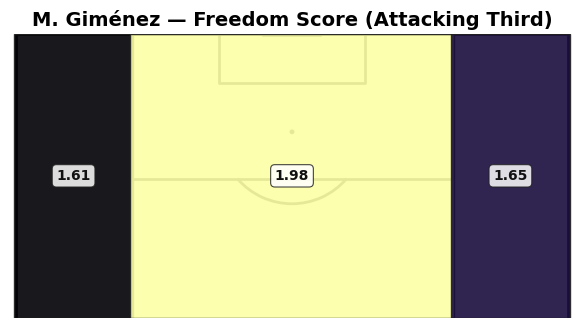

In [47]:
# =====================================================================
# ⚽ Freedom Score — Attacking Third by Channel (VerticalPitch, 100×100, Label Boxes)
# =====================================================================
from mplsoccer import VerticalPitch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd

player_name = "M. Giménez"
df = boca_attack_events.copy()

# --- Filter to player & attacking half only ---
player_df = df[df["playerName"].str.contains(player_name, case=False, na=False)].copy()
if player_df.empty:
    raise ValueError(f"No events found for {player_name}")

player_df = player_df[player_df["x"] > 50].copy()
if player_df.empty:
    raise ValueError(f"No attacking-half events found for {player_name}")

# --- Define channels (0–100) ---
def classify_channel(y):
    if y < 21:
        return "Left flank"
    elif y < 79:
        return "Central"
    else:
        return "Right flank"

player_df["channel"] = player_df["y"].apply(classify_channel)

# --- Compute freedom score per channel ---
zone_freedom = (
    player_df.groupby("channel", dropna=False)
    .apply(player_freedom)
    .reset_index(name="freedom_score")
)

channel_order = ["Left flank", "Central", "Right flank"]
zone_freedom["channel"] = pd.Categorical(zone_freedom["channel"], categories=channel_order, ordered=True)
zone_freedom = zone_freedom.sort_values("channel")

print("\n=== Attacking Third — Freedom Score per Channel ===")
print(zone_freedom.round(3))

# =====================================================================
# 🎨 Draw Vertical Pitch (100×100, Label Boxes)
# =====================================================================
pitch = VerticalPitch(
    pitch_type="opta",
    half=False,
    pitch_length=100,
    pitch_width=100,
    pitch_color="white",
    line_color="#222222",
    pad_left=0, pad_right=0, pad_top=0, pad_bottom=0
)

fig, ax = plt.subplots(figsize=(6, 9))
pitch.draw(ax=ax)
ax.set_title(f"{player_name} — Freedom Score (Attacking Third)", fontsize=14, fontweight="bold")

# --- Define attacking-third limits ---
third_x0, third_x1 = 66.7, 100
channel_bounds = {
    "Left flank": (0, 21),
    "Central": (21, 79),
    "Right flank": (79, 100)
}

# --- Color normalization ---
cmap = plt.cm.inferno  # great readability on dark background
norm = plt.Normalize(zone_freedom["freedom_score"].min(), zone_freedom["freedom_score"].max())

# --- Draw colored zones ---
for _, row in zone_freedom.iterrows():
    y0, y1 = channel_bounds[row["channel"]]
    color = cmap(norm(row["freedom_score"]))

    rect = patches.Rectangle(
        (y0 - 0.3, third_x0),
        (y1 - y0 + 0.6),
        (third_x1 - third_x0),
        linewidth=1.0,
        edgecolor="#222222",
        facecolor=color,
        alpha=0.9,
        zorder=2
    )
    ax.add_patch(rect)

    # --- Label box with contrasting edge ---
    ax.text(
        (y0 + y1) / 2,
        (third_x0 + third_x1) / 2,
        f"{row['freedom_score']:.2f}",
        ha="center",
        va="center",
        fontsize=10,
        fontweight="bold",
        color="#111111",   # darker text for better contrast
        zorder=4,
        bbox=dict(
            boxstyle="round,pad=0.3",
            fc="white",
            ec="#222222",
            lw=0.8,
            alpha=0.85
        )
    )

# --- Ensure full pitch visible ---
ax.set_xlim(-1, 101)
ax.set_ylim(third_x0, third_x1)



# --- Final layout adjustment ---
fig.subplots_adjust(left=0.03, right=0.97, top=0.93, bottom=0.05)
plt.show()


✅ Loaded 448 team scores from /Users/user/XG/Norway 2025/team_freedom_scores.csv

🏆 Top Teams by Normalized Freedom Index:
           team  freedom_index_0_100
0         Bryne            98.958144
1     Vålerenga            87.728646
2        Viking            81.234220
3   Fredrikstad            76.642963
4         Brann            74.573675
5     Haugesund            62.664251
6        HamKam            58.435981
7  Sarpsborg 08            46.946653
8    Sandefjord            43.166659
9         Molde            36.207644


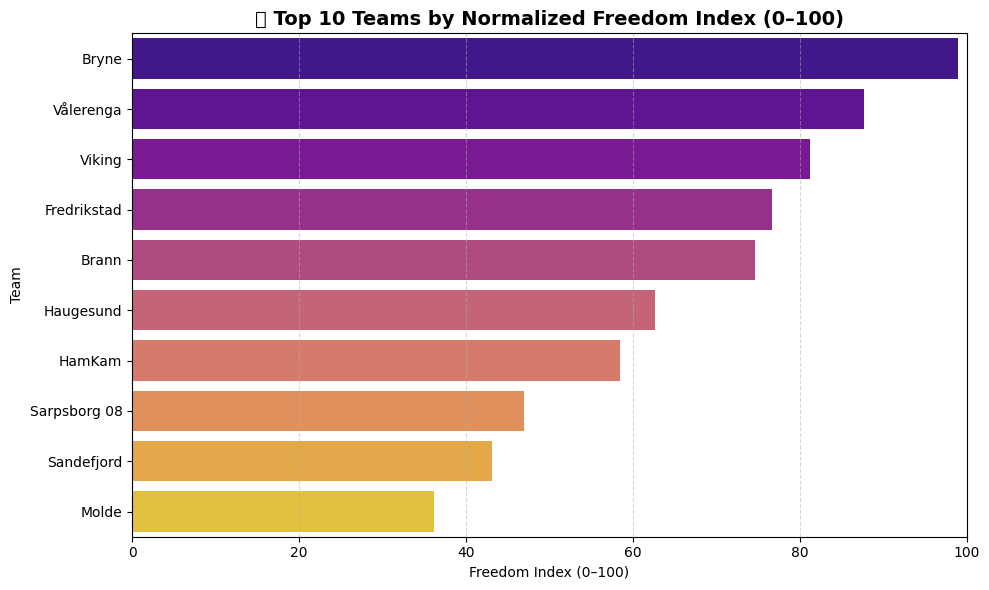

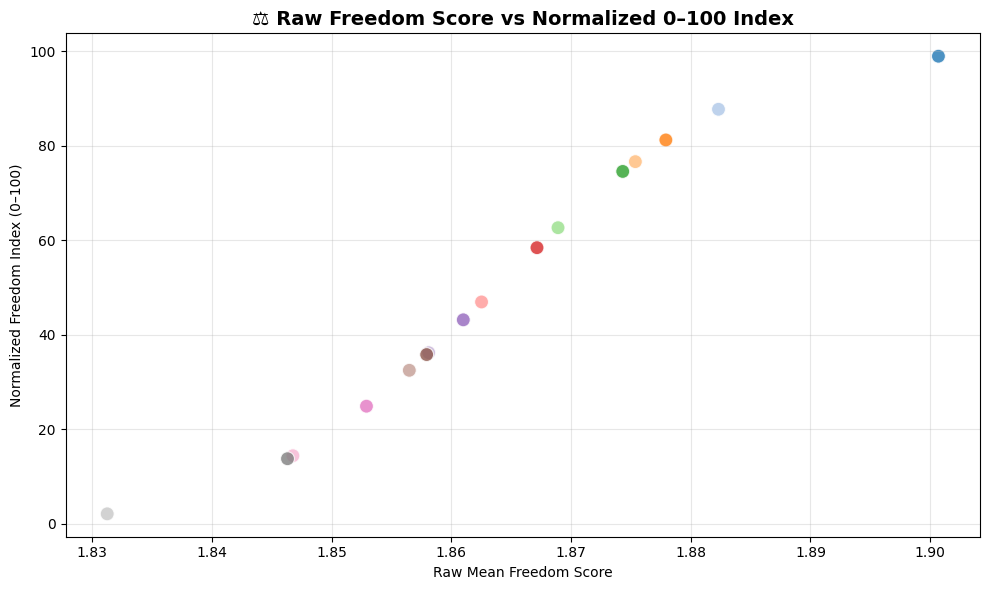

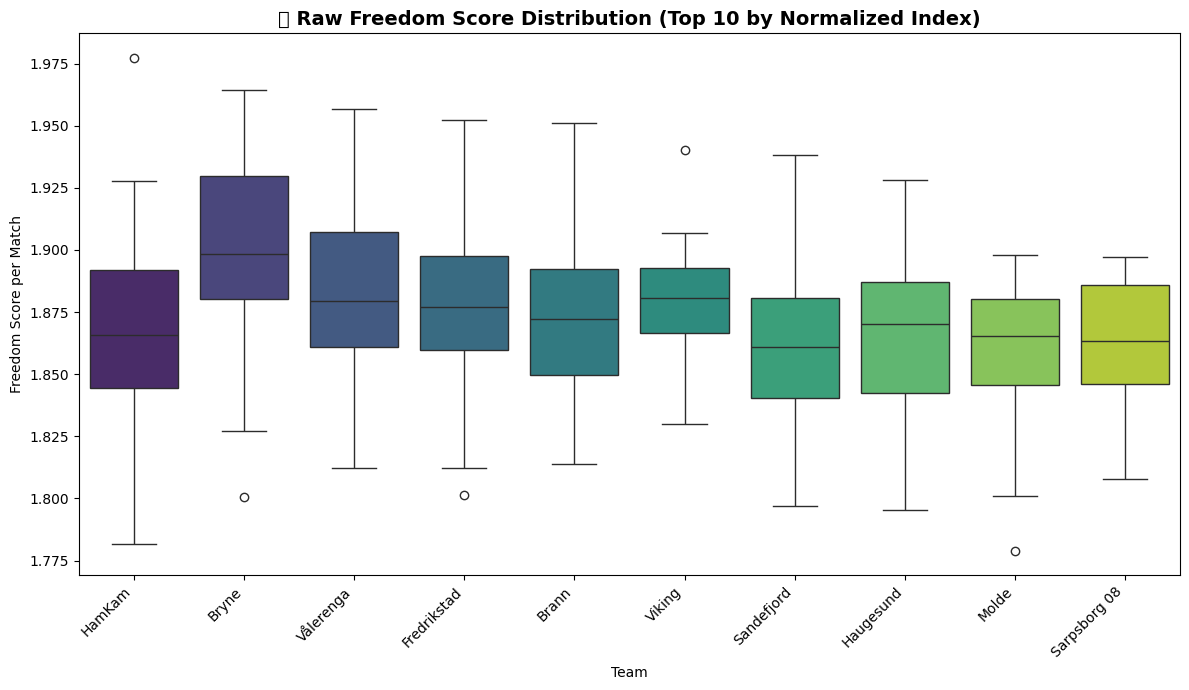

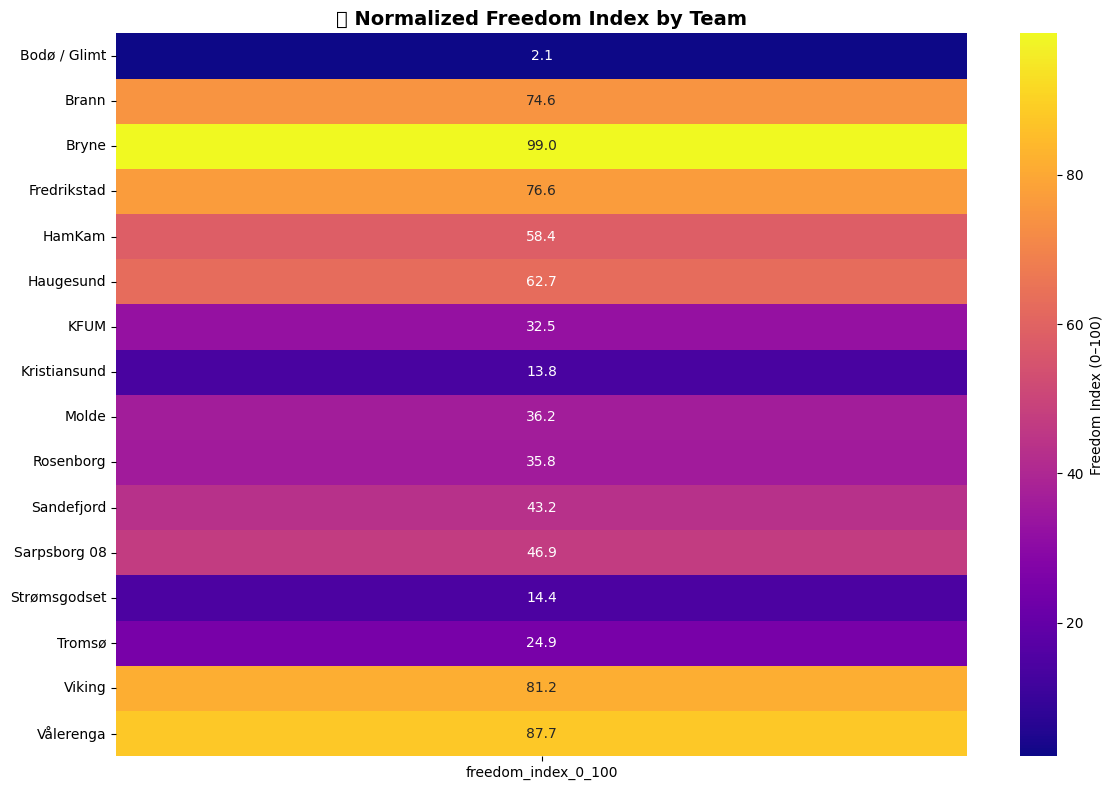

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

# =====================================================================
# LOAD TEAM FREEDOM SCORES
# =====================================================================
folder_path = "/Users/user/XG/Norway 2025"  # same as before
csv_path = os.path.join(folder_path, "team_freedom_scores.csv")

df = pd.read_csv(csv_path)
if df.empty:
    raise ValueError("CSV is empty or not found!")

print(f"✅ Loaded {len(df)} team scores from {csv_path}")

# =====================================================================
# CALCULATE TEAM AVERAGES
# =====================================================================
team_avg = (
    df.groupby("team")["team_freedom_score"]
    .agg(["mean", "std", "count"])
    .sort_values("mean", ascending=False)
    .reset_index()
)
team_avg["sem"] = team_avg["std"] / team_avg["count"] ** 0.5

# =====================================================================
# NORMALIZE USING Z-SCORES → SCALE 0–100
# =====================================================================
# z = (x - μ) / σ
mean_val = team_avg["mean"].mean()
std_val = team_avg["mean"].std(ddof=0)
team_avg["z_score"] = (team_avg["mean"] - mean_val) / std_val

# Convert z-scores to 0–100 scale (rough percentile transformation)
# CDF of normal → 0–1 → multiply by 100
from scipy.stats import norm
team_avg["freedom_index_0_100"] = norm.cdf(team_avg["z_score"]) * 100

# Rank order
team_avg = team_avg.sort_values("freedom_index_0_100", ascending=False).reset_index(drop=True)

print("\n🏆 Top Teams by Normalized Freedom Index:")
print(team_avg[["team", "freedom_index_0_100"]].head(10))

# =====================================================================
# 1️⃣ BARPLOT — NORMALIZED FREEDOM INDEX (0–100)
# =====================================================================
plt.figure(figsize=(10, 6))
sns.barplot(
    data=team_avg.head(10),
    x="freedom_index_0_100", y="team",
    palette="plasma", orient="h"
)
plt.title("🏆 Top 10 Teams by Normalized Freedom Index (0–100)", fontsize=14, fontweight="bold")
plt.xlabel("Freedom Index (0–100)")
plt.ylabel("Team")
plt.xlim(0, 100)
plt.grid(axis="x", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# =====================================================================
# 2️⃣ SCATTERPLOT — FREEDOM INDEX VS RAW MEAN
# =====================================================================
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=team_avg,
    x="mean", y="freedom_index_0_100", hue="team",
    palette="tab20", s=100, alpha=0.8, legend=False
)
plt.title("⚖️ Raw Freedom Score vs Normalized 0–100 Index", fontsize=14, fontweight="bold")
plt.xlabel("Raw Mean Freedom Score")
plt.ylabel("Normalized Freedom Index (0–100)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# =====================================================================
# 3️⃣ BOXPLOT — DISTRIBUTION OF RAW SCORES (TOP TEAMS)
# =====================================================================
top_teams = team_avg.head(10)["team"]
plt.figure(figsize=(12, 7))
sns.boxplot(
    data=df[df["team"].isin(top_teams)],
    x="team", y="team_freedom_score",
    palette="viridis"
)
plt.title("📦 Raw Freedom Score Distribution (Top 10 by Normalized Index)", fontsize=14, fontweight="bold")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Freedom Score per Match")
plt.xlabel("Team")
plt.tight_layout()
plt.show()

# =====================================================================
# 4️⃣ HEATMAP — FREEDOM INDEX BY TEAM (OPTIONAL)
# =====================================================================
plt.figure(figsize=(12, 8))
sns.heatmap(
    team_avg.pivot_table(values="freedom_index_0_100", index="team"),
    annot=True, fmt=".1f", cmap="plasma", cbar_kws={"label": "Freedom Index (0–100)"}
)
plt.title("🔥 Normalized Freedom Index by Team", fontsize=14, fontweight="bold")
plt.xlabel("")
plt.ylabel("")
plt.tight_layout()
plt.show()
